## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import logging

# Configure logging to prevent duplicate messages
# Clear any existing handlers first
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging with a single handler
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # This ensures reconfiguration if already configured
)

from utils.config import Config
from utils.validation import TensorModel, BatchModel
from utils.architecures import *
from utils.metrics import *
from utils.training import binary_validation_step
from utils.plots import plot_decision_boundary

2025-07-27 16:34:42,697 - INFO - NumExpr defaulting to 11 threads.


## Configs

- *We define the hyperparameters of our model in a dictionary and pass them to the `Config` class.*
- *We initialize a new experiment in Weights & Biases using the `wandb.init()` function. We specify the project, team, experiment name (for better tracking), and other context parameters.*

In [2]:
hyperparameters = {
    'name': 'neural-network-v3',
    'epochs': 200,
    'batch_size': 16,
    'hidden_size': [32, 16, 8],
    'learning_rate': 0.001,
    'n_features': 2,
    'weight_decay': 0.001,
    'patience': 20,  # Early stopping patience
    'min_delta': 1e-4  # Minimum change to qualify as an improvement
}

config = Config(hyperparameters)

2025-07-27 16:35:05,561 - INFO - Current device: mps


In [3]:
import wandb

# Log in to Weights & Biases. This will prompt you to enter your API key if not already logged in.
wandb.login()

# Initialize Weights & Biases. This will start a new run and log the hyperparameters.
run = wandb.init(
    project='pytorch-bootcamp',
    entity='nikossacoff-development',
    name=config.name,
    config={
        'model': 'NeuralNetworkV3',
        'optimizer': 'Adam',
        'criterion': 'BCEWithLogitsLoss',
        'hyperparameters': hyperparameters
    }
)

wandb: Currently logged in as: nicokossacoff (nikossacoff-development) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load data

- *We load our data using the `torch.load()` function. By using the `torch.Tensor.to()` method, we ensure the tensors are on the correct device (you can also use the `map_location` argument).*
- *We use `TensorModel` to validate the dimensions of the tensors.*

In [4]:
# Load tensors
train_data = torch.load('temp/data/binary-classification/train_data.pth').to(device=config.device)
val_data = torch.load('temp/data/binary-classification/validation_data.pth').to(device=config.device)
eval_data = torch.load('temp/data/binary-classification/evaluation_data.pth').to(device=config.device)

# Validate tensors
train_data = TensorModel(tensor=train_data, tensor_dimensions=2).tensor
val_data = TensorModel(tensor=val_data, tensor_dimensions=2).tensor
eval_data = TensorModel(tensor=eval_data, tensor_dimensions=2).tensor

In [5]:
# Split the data into features and labels
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_eval, y_eval = eval_data[:, :-1], eval_data[:, -1]

logging.info(f"Training data: {X_train.shape} | Labels: {y_train.shape}")
logging.info(f"Validation data: {X_val.shape} | Labels: {y_val.shape}")
logging.info(f"Evaluation data: {X_eval.shape} | Labels: {y_eval.shape}")

2025-07-27 16:35:37,818 - INFO - Training data: torch.Size([1400, 2]) | Labels: torch.Size([1400])
2025-07-27 16:35:37,818 - INFO - Validation data: torch.Size([300, 2]) | Labels: torch.Size([300])
2025-07-27 16:35:37,819 - INFO - Evaluation data: torch.Size([300, 2]) | Labels: torch.Size([300])
2025-07-27 16:35:37,818 - INFO - Validation data: torch.Size([300, 2]) | Labels: torch.Size([300])
2025-07-27 16:35:37,819 - INFO - Evaluation data: torch.Size([300, 2]) | Labels: torch.Size([300])


## Build an initial model

- *In this section, we will dive into a few important topics:*
    1. *First, we will discuss the different ways to build our model in PyTorch. In particular, we will introduce the `torch.nn.Sequential` module, which allows us to define the computational graph of our neural network using less code.*
    2. *Choose our loss function adn optimizer.*
    3. *Use `torch.utils.data.DataLoader` to easily iterate over training and validation data.*
    4. *How to track the model during training, which metrics to monitor, and how to interpret them.*
    5. *We will also review the different experiments performed and the various neural network architectures used. In particular, how we can benefit from using non-linear activation functions and deeper models.*

### PyTorch Models

- *Below is a PyTorch model where we define one hidden layer at a time. In this case, when we define the `forward()` method, we need to explicitly specify the computational graph of our neural network.*

In [ ]:
class NeuralNetworkV0(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, device: torch.device):
        super().__init__()
        # Create the first layer
        self.layer_1 = nn.Linear(input_size, hidden_size)
        # Create the second layer
        self.layer_2 = nn.Linear(hidden_size, 1)
        
        # Move the model to the specified device
        self.to(device)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        try:
            return self.layer_2(self.layer_1(x))
        except Exception as error:
            print(error)

- *Another option is to use the `nn.Sequential` module. This module allows us to implicitly define the computational graph of our neural network.*
- *It works as a container where we define the modules (i.e., layers) of our neural network in the order we want them to be executed when calling the `forward()` method, which helps reducing the amount of code.*
- *You can find more information about this module in the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html).*

In [ ]:
class NeuralNetworkV1(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, device: torch.device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Linear(hidden_size, 1)
        )
        
        self.to(device)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)
    
model = NeuralNetworkV1(
    input_size=config.n_features,
    hidden_size=config.hidden_size,
    device=config.device
)

### Instantiate model

In [6]:
# Instantiate the model
model = NeuralNetworkV3(
    input_size=config.n_features,
    hidden_size=config.hidden_size,
    device=config.device
)

### Loss function

- *For this binary classification problem, we will use the Binary Cross-Entropy loss function:*
$$
\begin{equation}
    L = -\frac{1}{N}\sum^{N}_{i=1}y_{i}\cdot\log{(\hat{y}_{i})}+(1-y_{i})\cdot\log{(1-\hat{y}_{i})}
\end{equation}
$$
- *PyTorch offers two modules to implement this loss function: `torch.nn.BCELoss` and `torch.nn.BCEWithLogitsLoss`. The main difference is that `torch.nn.BCEWithLogitsLoss` receives the model's raw scores, applies the sigmoid activation function to convert them into probabilities, and then computes the log-likelihood; whereas `torch.nn.BCELoss` expects to receive already normalized scores (probabilities).*
- *It is recommended to use `torch.nn.BCEWithLogitsLoss` for two reasons:*
    1. *There is no need to define the sigmoid activation function inside the model.*
    2. *Calculating probabilities and then applying the logarithm can cause numerical instabilities. Performing both operations in a single step improves stability.*

In [7]:
criterion = nn.BCEWithLogitsLoss()

### Optimizador

In [8]:
optimizer = optim.Adam(
    params=model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

### DataLoaders

- *`torch.utils.data.DataLoader` is a PyTorch module that facilitates efficient iteration over datasets.*
- *It allows you to generate batches (partitions of the dataset into smaller samples) and parallelize processing, optimizing model training and evaluation.*
- *It is built from a `torch.utils.data.Dataset` object, an abstract class that defines how to access and transform raw data. You can create custom modules that inherit from this class or use implementations already available in PyTorch.*
- *You can find more information in the [official documentation](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).*

In [9]:
# Create a TensorDataset instante for the training data and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
eval_dataset = TensorDataset(X_eval, y_eval)

# Create DataLoaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=config.batch_size, shuffle=False)

### Training Loop

- *Since this is a classification problem, in addition to calculating the loss function for the training and validation samples, we will compute the following metrics:*
    - **Accuracy**. *The number of observations our model classified correctly out of the total number of observations.*
    - **Precision**. *The number of observations correctly classified as positive (i.e., $y=1$) out of all observations predicted as positive. This measures how efficient our model is. Maximizing precision reduces false positives.*
    - **Recall**. *The number of observations correctly classified as positive (i.e., $y=1$) out of all actual positive observations. This measures how well our model captures positives. Maximizing recall reduces false negatives.*
    - **F1-Score**. *The harmonic mean of precision and recall. It indicates how well our model balances false positives and false negatives.*
- *We also compute other metrics that help us understand whether the model is generalizing well:*
    - **Weight norm**. *The norm of the model weights.*
        - *Reasons we monitor model weights:*
            - *Increasing model weights can signal poor generalization and potential overfitting. By tracking weight norms during training, we gain insight into the model's learning dynamics and can detect overfitting earlier.*
            - *Weight decay is a regularization technique that penalizes large weights, helping to prevent overfitting. Monitoring weight norms allows us to evaluate the effectiveness of weight decay and other regularization strategies.*
        - *Typically, model weights grow during the initial training phases as the network learns from the data (remember that weights are usually initialized with small random values), then stabilize or decrease as training progresses and the model converges. Observing these trends helps ensure healthy training and model stability.*
    - **Gradient norm**. *The norm of the gradients.*
        - *The gradients of the loss function with respect to the model weights indicate the direction of greatest increase (we want to move in the opposite direction). Usually, we care more about the direction than the magnitude. Normalizing gradients can improve training stability, though it's not always the best option (see more in this [post](https://stats.stackexchange.com/questions/22568/difference-in-using-normalized-gradient-and-gradient)).*
        - *Things to keep in mind:*
            - *If the gradient norm is very close to zero (i.e., gradients are near zero), we have a vanishing gradient problem. In this case, weights are not updated and the model stops learning.*
            - *If the gradient norm is very large (i.e., gradients are growing rapidly), we have an exploding gradient problem. This can indicate instability during training.*
            - *A sudden drop in the gradient norm may reflect premature convergence or that the model has reached a local minimum or saddle point.*

#### Early Stopping

- *Early stopping is a regularization technique used to prevent overfitting by monitoring the validation loss during training. The algorithm stops training when the validation loss stops improving for a specified number of epochs (patience).*
- *Key parameters:*
    - `patience`: *The number of epochs to wait for improvement before stopping training.*
    - `min_delta`: *The minimum change in validation loss to qualify as an improvement.*
- *Benefits:*
    - *Prevents overfitting by stopping training at the optimal point.*
    - *Saves computational time by avoiding unnecessary epochs.*
    - *Automatically finds the best model without manual intervention.*

In [11]:
# Accumulate the training loss 
train_loss_accum = 0.0

# Accumulate the validation loss.
validation_loss_accum = 0.0

# Count the number of epochs without improvement.
# If the validation loss is lower than the best validation loss (minus a small delta value), we reset the counter to 0.
# If the validation loss is not lower than the best validation loss, we increment the counter by 1. When counter = patience, we stop the training.
counter = 0
best_val_loss = float('inf')

# Early stopping parameters
patience = config.patience if hasattr(config, 'patience') else 20
min_delta = config.min_delta if hasattr(config, 'min_delta') else 1e-4

for epoch in np.arange(config.epochs):
    # Accumulate the training and validation loss 
    train_loss_accum = 0.0
    validation_loss_accum = 0.0

    ### Training phase
    for (X_train, y_train) in train_loader:
        # Set model to training mode
        model.train()
        
        # Forward pass.
        # The loss function expects the shape of the model's output to be the same as the ground truth.
        # Since this is a binary classification problem, the ground truth tensor is of shape (N,)
        # We use .squeeze() to ensure the model's output is also of shape (N,).
        outputs = model(X_train)
        outputs = outputs.squeeze()

        # Compute the loss
        train_loss = criterion(outputs, y_train.float())
        # Accumulate the training loss
        train_loss_accum += train_loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        train_loss.backward()

        # Calculate the norm of the gradients. We don't clip the gradients here, but you can do so if needed.
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Calculate the norm of the weights
        weight_norm = torch.norm(torch.stack([torch.norm(param) for param in model.parameters()]))

        # Log the gradients and weights norms
        run.log({
            'Training/Gradient Norm': grad_norm,
            'Training/Weight Norm': weight_norm
        })

        # Update the weights
        optimizer.step()

    #### Inference phase
    val_results = binary_validation_step(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=config.device
    )

    # Log metrics on validation set
    run.log({
        'Metrics/Accuracy': val_results['accuracy'],
        'Metrics/Precision': val_results['precision'],
        'Metrics/Recall': val_results['recall'],
        'Metrics/F1-Score': val_results['f1_score']
    })

    # Average the training and validation loss
    train_loss = train_loss_accum / len(train_loader)

    # Log the training loss for the whole epoch
    run.log({
        'Training/Training Loss': train_loss,
        'Training/Validation Loss': val_results['loss']
    })

    #### Early stopping logic
    # Check if we have improvement (considering min_delta)
    if val_results['loss'] < best_val_loss - config.min_delta:
        # Update the best validation loss. Current validation loss is the best one so far.
        best_val_loss = val_results['loss']

        # Reset the counter
        counter = 0

        # Save the best model so far. This allows us to restore the best model after training.
        torch.save(model.state_dict(), f'temp/models/{config.name}/best-model.pth')
        logging.info(f"Epoch {epoch + 1}: New best validation loss: {best_val_loss:.6f}")
    else:
        counter += 1
        logging.info(f"Epoch {epoch + 1}: No improvement. Counter: {counter}/{config.patience}")

    if counter >= config.patience:
        logging.info(f"Early stopping triggered! No improvement for {config.patience} epochs.")
        logging.info(f"Best validation loss: {best_val_loss:.6f} at epoch {epoch + 1 - config.patience}")
        break
    
    #### Show training progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Training loss: {train_loss:.4f} | Validation loss: {val_results['loss']:.4f}")
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Accuracy: {val_results['accuracy']:.4f} | F1-Score: {val_results['f1_score']:.4f}\n")

2025-07-27 16:36:47,896 - INFO - Epoch 1: New best validation loss: 0.691598
2025-07-27 16:36:48,300 - INFO - Epoch 2: New best validation loss: 0.685282
2025-07-27 16:36:48,702 - INFO - Epoch 3: New best validation loss: 0.671900
2025-07-27 16:36:49,099 - INFO - Epoch 4: New best validation loss: 0.645585
2025-07-27 16:36:49,494 - INFO - Epoch 5: New best validation loss: 0.571162
2025-07-27 16:36:49,880 - INFO - Epoch 6: New best validation loss: 0.453322
2025-07-27 16:36:50,270 - INFO - Epoch 7: New best validation loss: 0.325226
2025-07-27 16:36:50,666 - INFO - Epoch 8: New best validation loss: 0.224836
2025-07-27 16:36:51,058 - INFO - Epoch 9: New best validation loss: 0.147591
2025-07-27 16:36:51,455 - INFO - Epoch 10: New best validation loss: 0.103780
2025-07-27 16:36:51,847 - INFO - Epoch 11: New best validation loss: 0.075917
2025-07-27 16:36:52,240 - INFO - Epoch 12: New best validation loss: 0.059836
2025-07-27 16:36:52,628 - INFO - Epoch 13: New best validation loss: 0.05

- *We use the `torch.save()` function to save our model's weights (saving the weights is usually sufficient and recommended).*

In [12]:
# Load the best model if early stopping was used
best_model_path = f'temp/models/{config.name}/best-model.pth'
if os.path.exists(best_model_path):
    # Loads the best model state dictionary
    logging.info("Loading best model from early stopping...")
    model.load_state_dict(torch.load(best_model_path))

    # Saves the best model as the final model
    torch.save(model.state_dict(), f'temp/models/{config.name}/model.pth')
else:
    # Save current model if no early stopping occurred
    torch.save(model.state_dict(), f'temp/models/{config.name}/model.pth')

# Save hyperparameters if not already saved
with open(f'temp/models/{config.name}/hyperparameters.pkl', 'wb') as f:
    pickle.dump(hyperparameters, f)

2025-07-27 16:37:48,264 - INFO - Loading best model from early stopping...


- *In addition to saving the weights locally, we create a `wandb.Artifact` instance to store the model weights remotely. This ensures they are available to anyone accessing the experiment on the web.*
- *We also finish the current run with the `wandb.finish()` function. All artifacts should be already saved.*

In [ ]:
# Generate a wandb artifact for the model
model_artifact = wandb.Artifact(
    name=config.name,
    type='model',
    metadata={
        'input_size': config.n_features,
        'hidden_size': config.hidden_size,
        'epochs': config.epochs,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'weight_decay': config.weight_decay,
        'patience': config.patience,
        'min_delta': config.min_delta,
        'best_val_loss': best_val_loss,
        'early_stopped': counter >= config.patience
    }
)
model_artifact.add_file(f'temp/models/{config.name}/model.pth', name='model.pth')
run.log_artifact(model_artifact)

# Finish the Weights & Biases run
run.finish()  

### Experiments

#### First experiment

- *The initial model, `NeuralNetworkV1`, features a single hidden layer with five neurons. As demonstrated in this [experiment](https://wandb.ai/nikossacoff-development/pytorch-bootcamp/runs/6ojc8v02?nw=nwusernicokossacoff), the training outcomes were suboptimal.*
- *The loss function exhibits only a slight decrease, remaining far from zero by the end of training. Performance metrics—including accuracy, precision, recall, and F1-score—indicate that the model struggles to capture the underlying data patterns. Additionally, the weight norms consistently decrease throughout training, suggesting limited learning capacity and potential underfitting.*
- *Looking at the decision boundary, you can see our model tries to fit the data with a straight line. However, the data is clearly non-linear, so the model struggles to classify examples correctly. Our model is not flexible enough for this complex, non-linear problem.*

Text(0.0, 1.0, 'Test')

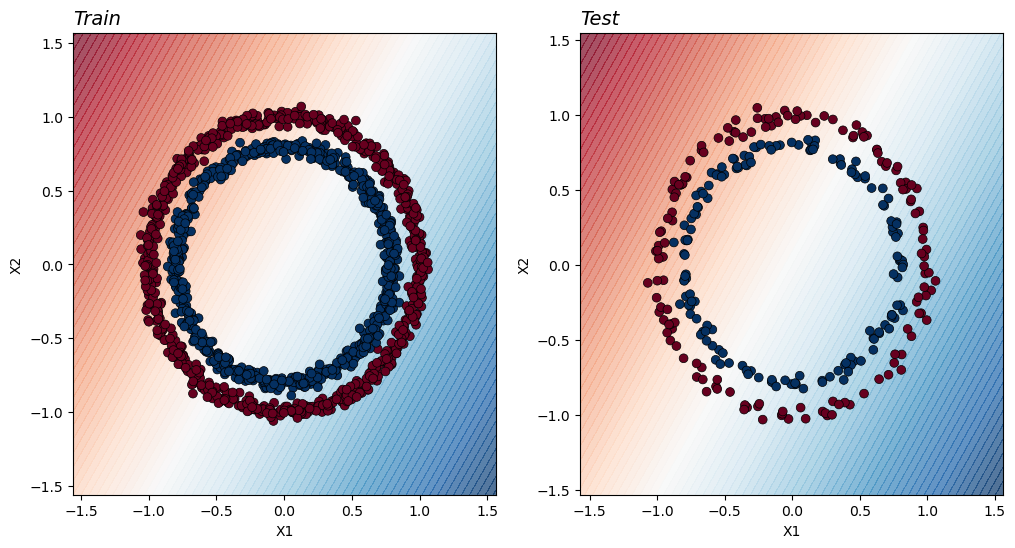

In [16]:
# Load the hyperparameters from the saved model
with open('temp/models/neural-network-v1/hyperparameters.pkl', 'rb') as f:
    hyperparameters = pickle.load(f)

# Instantiate the model for plotting decision boundaries
model = NeuralNetworkV1(
    input_size=hyperparameters['n_features'],
    hidden_size=hyperparameters['hidden_size'],
    device=config.device
)

# Load the weights from the saved model
state_dict = torch.load('temp/models/neural-network-v1/model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Plot the decision boundary for the training and test datasets
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

plot_decision_boundary(model, train_data[:, :-1], train_data[:, -1], ax=ax[0])
ax[0].set_title("Train", loc='left', fontdict={'size': 14, 'style': 'italic'})
plot_decision_boundary(model, eval_data[:, :-1], eval_data[:, -1], ax=ax[1])
ax[1].set_title("Test", loc='left', fontdict={'size': 14, 'style': 'italic'})

#### Second experiment

- *One way to improve our neural network's performance is by increasing the number of hidden layers and neurons.*
- *Neural networks are mathematical entities, $\hat{f}$, that aim to approximate a continuous, multivariate function, $f$.*
- *We can represent a neural network as a composition of functions (each function represents a layer within our network):$$\hat{f}(x)=f^{(n)}\left(f^{(n-1)}\left(\ldots\left(f^{(1)}(x)\right)\right)\right)$$ where $f^{(i)}$ is a function that takes a vector as input and returns another vector as output. Each element of the output vector is a non-linear transformation of the input.*
- *Stacking multiple hidden layers allows the network to learn complex representations (we often say it learns the underlying patterns in the data), which it uses to approximate the target function $f$.*
- *Howecer, even after adding more hidden layers and neurons, our model still struggles to fit the data. If you look at the training curves (see the [experiment](https://wandb.ai/nikossacoff-development/pytorch-bootcamp/runs/k0eklupe?nw=nwusernicokossacoff) here), you'll notice only a slight reduction in the loss function and a sharp drop in the weight norms (usually a sign of underfitting).*

/Users/nicolaskossacoff/Documents/Projects/data-science-library/coding/py-torch/01-classification/utils/plots.py:57: UserWarning: Model predictions have very low variation. This may indicate that the model is not properly trained or lacks non-linear activation functions.
  warnings.warn("Model predictions have very low variation. This may indicate that the model is not properly trained or lacks non-linear activation functions.")


Text(0.0, 1.0, 'Test')

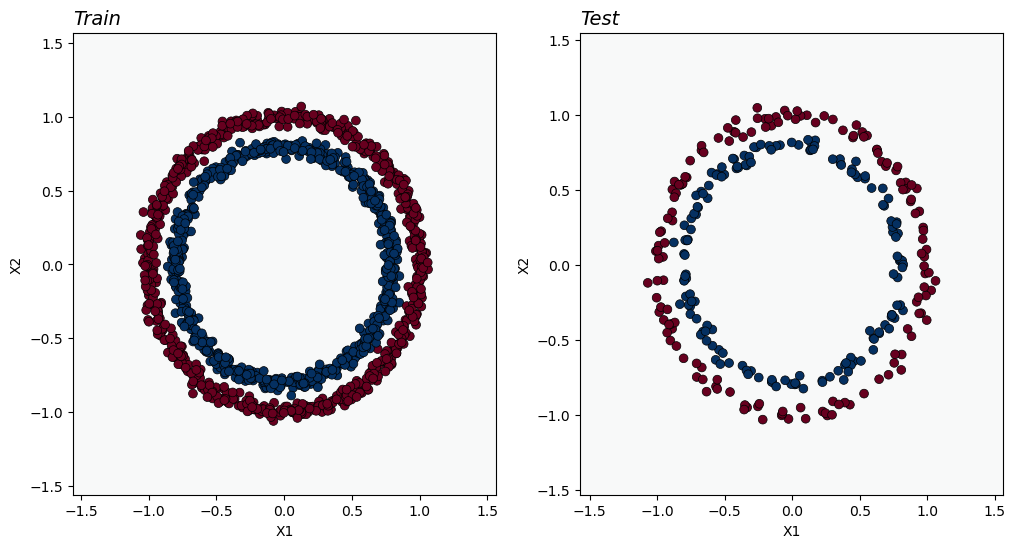

In [15]:
# Load the hyperparameters from the saved model
with open('temp/models/neural-network-v2/hyperparameters.pkl', 'rb') as f:
    hyperparameters = pickle.load(f)

# Instantiate the model for plotting decision boundaries
model = NeuralNetworkV2(
    input_size=hyperparameters['n_features'],
    hidden_size=hyperparameters['hidden_size'],
    device=config.device
)

# Load the weights from the saved model
state_dict = torch.load('temp/models/neural-network-v2/model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Plot the decision boundary for the training and test datasets
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

plot_decision_boundary(model, train_data[:, :-1], train_data[:, -1], ax=ax[0])
ax[0].set_title("Train", loc='left', fontdict={'size': 14, 'style': 'italic'})
plot_decision_boundary(model, eval_data[:, :-1], eval_data[:, -1], ax=ax[1])
ax[1].set_title("Test", loc='left', fontdict={'size': 14, 'style': 'italic'})

#### Third experiment

- *So far, our models have struggled because they can't learn non-linear patterns—mainly because we've left out a crucial ingredient: activation functions.*
- *Activation functions introduce non-linearity into neural networks, letting them capture complex relationships in the data. Without them, a neural network is just a fancy linear model, no matter how many layers you stack.*
- *The most popular activation function is ReLU (Rectified Linear Unit): $$\text{ReLU}(x) = \max\{0, x\}$$. It's simple, fast, and works well in practice.*
- *After adding ReLU activations to our model (`NeuralNetworkV3`), performance improves dramatically (see the [experiment](https://wandb.ai/nikossacoff-development/pytorch-bootcamp/runs/cynsmfs4?nw=nwusernicokossacoff) here). The loss drops close to zero, and metrics like accuracy, precision, recall, and F1-score all hit perfect scores. The weight norms show healthy growth and then stabilize, which is a good sign.*
- *The decision boundary now matches the non-linear structure of the data, showing that our model finally "gets" the underlying patterns.*

Text(0.0, 1.0, 'Test')

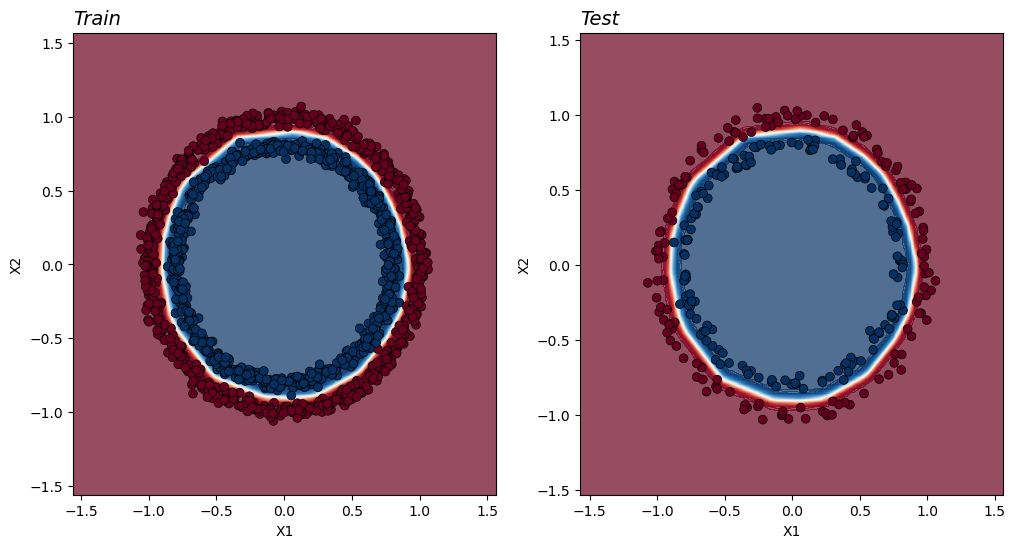

In [14]:
# Load the hyperparameters from the saved model
with open('temp/models/neural-network-v3/hyperparameters.pkl', 'rb') as f:
    hyperparameters = pickle.load(f)

# Instantiate the model for plotting decision boundaries
model = NeuralNetworkV3(
    input_size=hyperparameters['n_features'],
    hidden_size=hyperparameters['hidden_size'],
    device=config.device
)

# Load the weights from the saved model
state_dict = torch.load('temp/models/neural-network-v3/model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Plot the decision boundary for the training and test datasets
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

plot_decision_boundary(model, train_data[:, :-1], train_data[:, -1], ax=ax[0])
ax[0].set_title("Train", loc='left', fontdict={'size': 14, 'style': 'italic'})
plot_decision_boundary(model, eval_data[:, :-1], eval_data[:, -1], ax=ax[1])
ax[1].set_title("Test", loc='left', fontdict={'size': 14, 'style': 'italic'})